In [58]:
import os
import glob
import numpy as np
import pandas as pd

all_files = glob.glob(os.path.join("..", "var", "mixtures old.csv"))

df = pd.concat((pd.read_csv(f, header=None) for f in all_files), ignore_index=True)

In [59]:
df = df.drop_duplicates()

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.1,0.9,3,1,5,5,3,0,0,2,1.52,1.1,1.1,1.52,1.0
1,0.1,0.9,3,1,5,5,3,0,0,3,1.52,1.1,1.1,1.52,1.0
2,0.1,0.9,3,2,3,3,1,0,0,1,1.52,1.1,1.1,1.52,1.0
3,0.1,0.9,3,2,3,3,1,0,0,2,1.52,1.1,1.1,1.52,1.0
4,0.1,0.9,3,2,3,3,1,0,0,3,1.52,1.1,1.1,1.52,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14334,0.9,0.1,3,3,5,5,2,0,0,2,1.52,1.1,1.1,1.52,1.0
14335,0.9,0.1,3,3,5,5,2,0,0,3,1.52,1.1,1.1,1.52,1.0
14336,0.9,0.1,3,3,5,5,3,0,0,1,1.52,1.1,1.1,1.52,1.0
14337,0.9,0.1,3,3,5,5,3,0,0,2,1.52,1.1,1.1,1.52,1.0


In [60]:
df = df.drop(df[df[14] == 1].sample(frac=.97).index)

<AxesSubplot:>

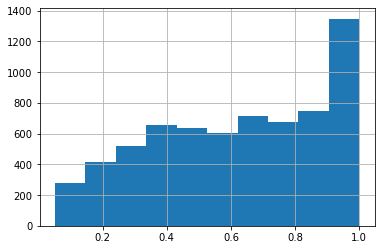

In [61]:
df[14].hist()

In [62]:
y = df[range(0, 14)].to_numpy()
X = df[14].to_numpy().reshape(-1, 1)

In [63]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [64]:
batch_size = 64

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [65]:
from torch import nn
from torch import optim

input_dim = 1
hidden_dim = 100
output_dim = y.shape[1]

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.layer2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.layer3 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.layer4 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.layer5 = nn.Linear(in_features=hidden_dim, out_features=output_dim)

        self.activation = torch.nn.LeakyReLU()
        self.softmax = torch.nn.Softmax(dim=1)
       
    def forward(self, x):
        y = self.layer1(x)
        y = self.activation(y)

        y = self.layer2(y)
        y = self.activation(y)

        y = self.layer3(y)
        y = self.activation(y)

        y = self.layer4(y)
        y = self.activation(y)

        y = self.layer5(y)

        first_slice = y[:, 0:2]
        second_slice = y[:, 2:]
        tuple_of_activated_parts = (
            self.softmax(first_slice),
            second_slice
        )

        #print(self.softmax(first_slice).shape)
        #print(second_slice.shape)

        y = torch.cat(tuple_of_activated_parts, dim=1)

        #print(y.shape)

        #print(self.softmax(first_slice))

        #raise Exception()

        return y
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer1): Linear(in_features=1, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=100, bias=True)
  (layer5): Linear(in_features=100, out_features=14, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
)


In [66]:
learning_rate = 1e-5

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
from tqdm import tqdm

num_epochs = 200
loss_values = []

for epoch in tqdm(range(num_epochs)):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


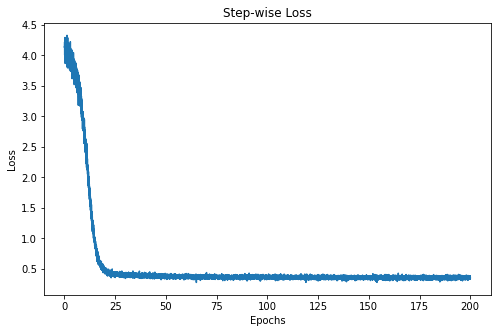

In [68]:
import matplotlib.pyplot as plt

step = np.linspace(0, num_epochs, len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [69]:
min(loss_values)

0.2763844430446625

In [70]:
from moebius import olr

def olr_from_plain(x):
    return olr([x[0],  x[1]],  [[x[2],  x[3]],  [x[4],
         x[5]]],  [[[x[6], x[7]],  [x[8],  x[9]]],
         [[x[10],  x[11]],  [x[12], x[13]]]])

In [71]:
i = 0
mse = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)

        # print(outputs[0])
        # print(X[0], olr_from_plain(outputs[0]))

        # break

        # print(outputs.shape)

        for i, output in enumerate(outputs):
            true = X[i][0].item()
            predicted_params = outputs[i]
            predicted_olr = olr_from_plain(predicted_params)
            predicted_olr = predicted_olr[0] if isinstance(predicted_olr, list) else predicted_olr

            predicted_olr = predicted_olr.item() if torch.is_tensor(predicted_olr) else predicted_olr

#             print(predicted_olr)
#             print(true)
#             print(predicted_params)

            # predicted_olr -= 0.15

            mse += (true - predicted_olr) ** 2
            total += 1

            # if total >= 10:
            #   break

        break

print(mse / total)

0.04876423049867245
